# <center>Side Radar Analysis from 10-14-2022 data</center>
<center>Jonathan Sprinkle, Matt Nice</center>
<center>Vanderbilt University</center>

Instructions for use:
1. Replace the base folders to match the descriptions of where your files are
1. Modify the name of the data file(s) you are using
1. Press Run to see the basic data values plotted in a single instance

Advanced properties:
1. Establish the time difference between dashcam (if any) and the data timestamps


## Preliminary things to do
1. clone strym somewhere on your computer: `cd strym_location && git clone https://github.com/jmscslgroup/strym.git`
1. get the datafile(s) from cyverse: `cd nissan_test_folder && irsync -r -v i:/iplant/home/mnice/nissan_test .`

In [27]:
import numpy as np
import matplotlib.pyplot as pt
import csv
import pandas as pd
import cantools 
import matplotlib.animation as animation
from matplotlib import style
from haversine import haversine, Unit
import time
import strym as s
from strym import strymread
from datetime import datetime
import math

%config IPKernelApp.matplotlib = 'inline'
%config InlineBackend.figure_format ='retina'

nissan_test_folder='/Users/sprinkle/work/data/nissan_test/'

strym_location='/Users/sprinkle/work/research/circles/strym-dev/'
dbc_folder=strym_location+'strym/dbc/'

# load the dbc file for later use
dbcfile=dbc_folder + 'nissan_rogue_2021.dbc'
db = cantools.database.Database()
with open(dbcfile,'r') as fin:
    db = cantools.database.load(fin)

In [3]:
# list your datafiles you plan to use
datafile = '2022-09-19-19-16-51_JN8AT3CB9MW240939_CAN_Messages.csv'
datafile_side = '2022-09-19-19-17-31_JN8AT3CB9MW240939_CAN_Messages.csv'

## Load boilerplate code that will be used often

In [4]:
def getUnixTimeFromTimestamp(date_string):
    """Input string formatted as %Y-%m-%d %H:%M:%S"""
    from datetime import datetime
    myUnixTime = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S')
#     result = datetime.utcfromtimestamp(myUnixTime.strftime('%Y-%m-%d %H:%M:%S'))
    result = myUnixTime.timestamp() - 6*3600
    return result

# a function that overlays timed events on an existing plot
def overlayEvents( ax, redEvents, blueEvents, grayEvents, fudgeFactor=0, relativeTime=0 ):
    """Pass in the axis of a figure. Event are arrays of times to be put on the """
    for ev in redEvents:
        ax.axvline(ev+fudgeFactor-relativeTime,0,1,color='red')
    for ev in blueEvents:
        ax.axvline(ev+fudgeFactor-relativeTime,0,1,color='blue')
    for ev in grayEvents:
        ax.axvline(ev+fudgeFactor-relativeTime,0,1,color='gray')

def getMinicarChanges(minicar_data):
    """Returns a tuple of times when minicar changes take place. 
    
    The input is a dataframe subset of decoded minicar signals.
    
    The values returned appearances: times when the minicar goes from off to on
    disapperances: times when the minicar goes from on to off """
    result = []
    states = strymread.create_chunks(data, column_of_interest='Message',continuous_threshold=0.5)
    for mc in states:
        if mc.iloc[0].Message == 0:
            continue
        elif mc.iloc[0].Message == 1:
            start = mc.iloc[0].Time
            end = mc.iloc[-1].Time
#             print('State runs from ', start, ' to ', end)
            if data.iloc[0].Time == start:
#                 print('skipping first instance')
                continue
            elif data.iloc[-1].Time == end:
#                 print('skipping last instance')
                continue
            else:
                result.append([start,end])
#         else:
#             print('oops')

    return result

def getTimeWindow(data, t0 = None, t1 = None, relative = False):
    """Return the time window dataframe that is between (and including if applicable) [t0, t1]"""
    if relative == True:
        if t0:
            t0 = data.iloc[1].Time + t0
        if t1:
            t1 = data.iloc[1].Time + t1
    if t0:
        data = data.loc[data.Time >= t0]
    if t1:
        data = data.loc[data.Time <= t1]
    return data


# Load the data

In [5]:
dataframe = pd.read_csv(nissan_test_folder+'/'+datafile)
dataframe_side = pd.read_csv(nissan_test_folder+'/'+datafile_side)

In [6]:
# list important times that are gathered from dashcam information
# once more with more information to validate across a longer time horizon
minicar_appears = []
minicar_disappears = []
cutin = []

start = getUnixTimeFromTimestamp('2022-09-19 20:43:25') 
minicar_appears.append(getUnixTimeFromTimestamp('2022-09-19 20:43:28')) # minicar appears
cutin.append(getUnixTimeFromTimestamp('2022-09-19 20:44:13')) # cutin closer
cutin.append(getUnixTimeFromTimestamp('2022-09-19 20:44:18')) # lead veh got out of the way
cutin.append(getUnixTimeFromTimestamp('2022-09-19 20:48:18')) # lead veh got out of the way
cutin.append(getUnixTimeFromTimestamp('2022-09-19 20:48:35')) # ego veh changes lanes
cutin.append(getUnixTimeFromTimestamp('2022-09-19 20:49:12')) # cutin closer
cutin.append(getUnixTimeFromTimestamp('2022-09-19 20:49:34')) # lead veh got out of the way
minicar_disappears.append(getUnixTimeFromTimestamp('2022-09-19 20:49:37')) # minicar disappears
end = getUnixTimeFromTimestamp('2022-09-19 20:49:33') + 10

# text of start/end times
start_txt = datetime.utcfromtimestamp(start).strftime('%H:%M:%S')
end_txt = datetime.utcfromtimestamp(end).strftime('%H:%M:%S')

# videoFudgeFactor: difference between time for video, and time for the rpi
videoFudgeFactor=1.3

print('Video timestamps should run from ', start_txt,' to ', end_txt, 
      ', and will be approximately', videoFudgeFactor, 's behind the CAN data.')

Video timestamps should run from  19:43:25  to  19:49:43 , and will be approximately 1.3 s behind the CAN data.


In [7]:
dataframe_window = getTimeWindow(dataframe,start,end)

[2022_09_29_10_29_53] (numexpr.utils) INFO: NumExpr defaulting to 8 threads.


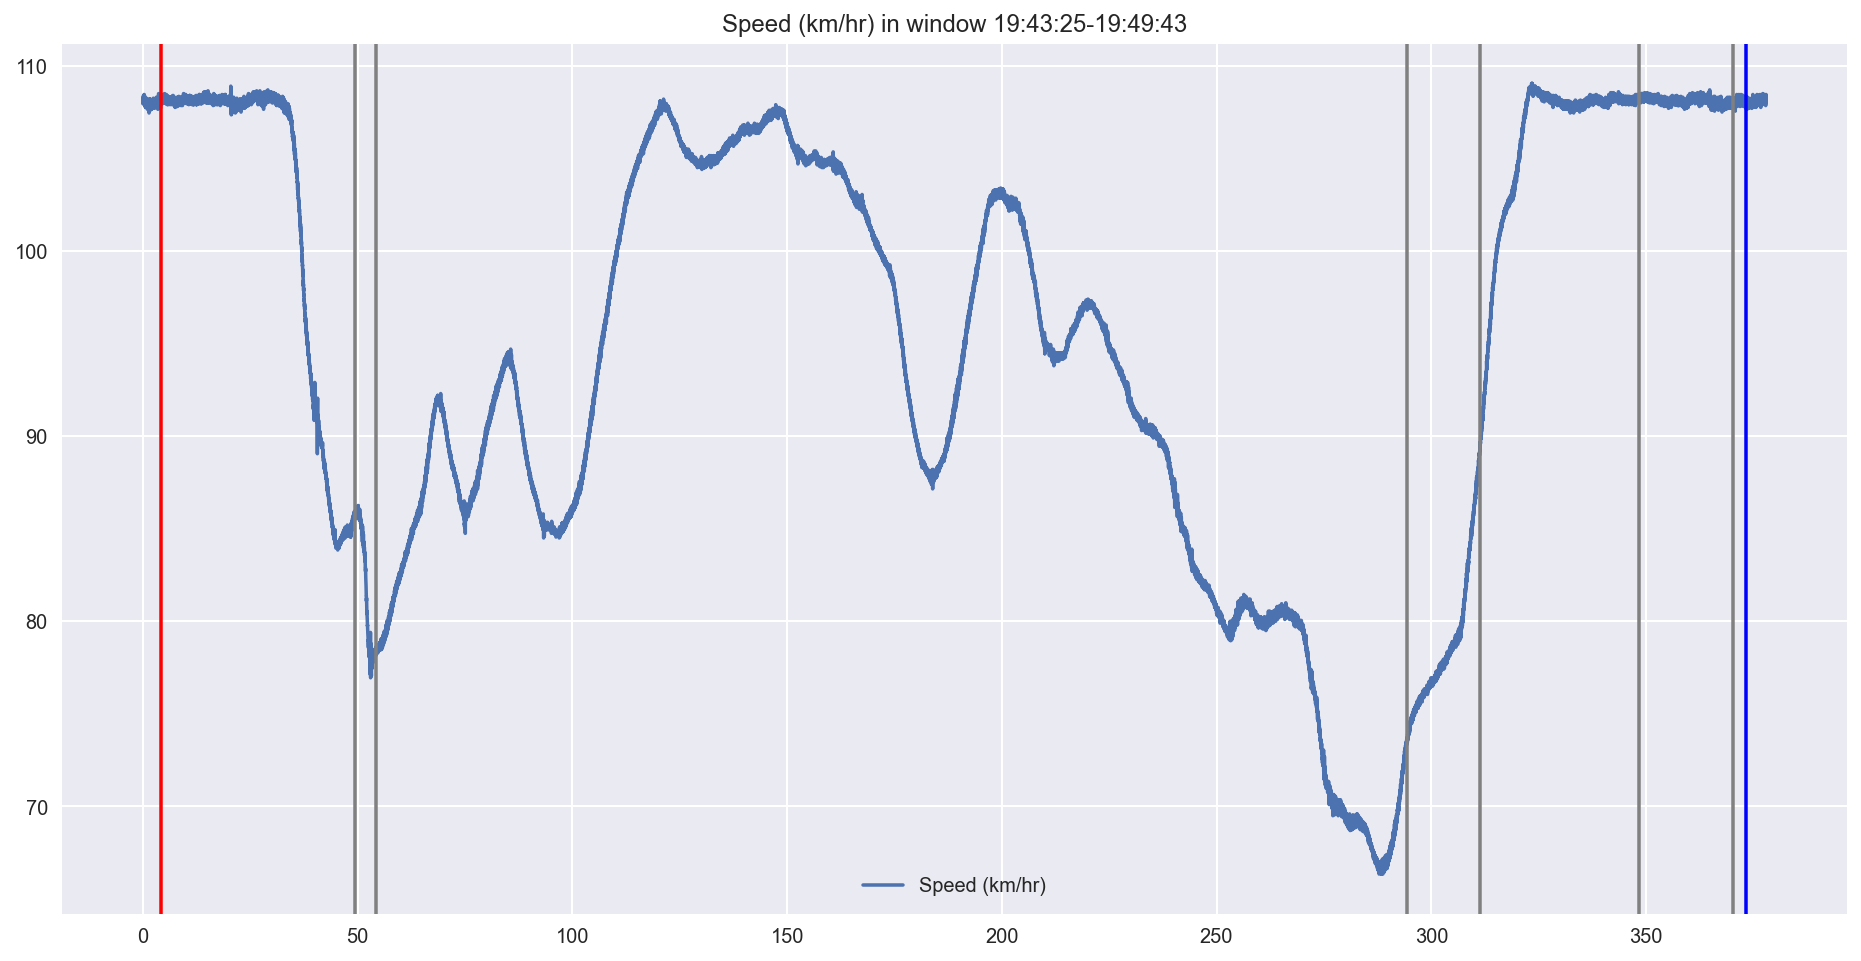

In [8]:
# now, we get and plot a bunch of stuff
speed = s.convertData('SPEED','SPEED',dataframe_window,db)
# subtract the start time to show relative time in the plot
pt.plot(speed.Time-start,speed.Message, label='Speed (km/hr)')
pt.title('Speed (km/hr) in window ' + start_txt + '-' + end_txt)
pt.legend()
overlayEvents(pt.gca(), minicar_appears, minicar_disappears, cutin, fudgeFactor=videoFudgeFactor, relativeTime=start)

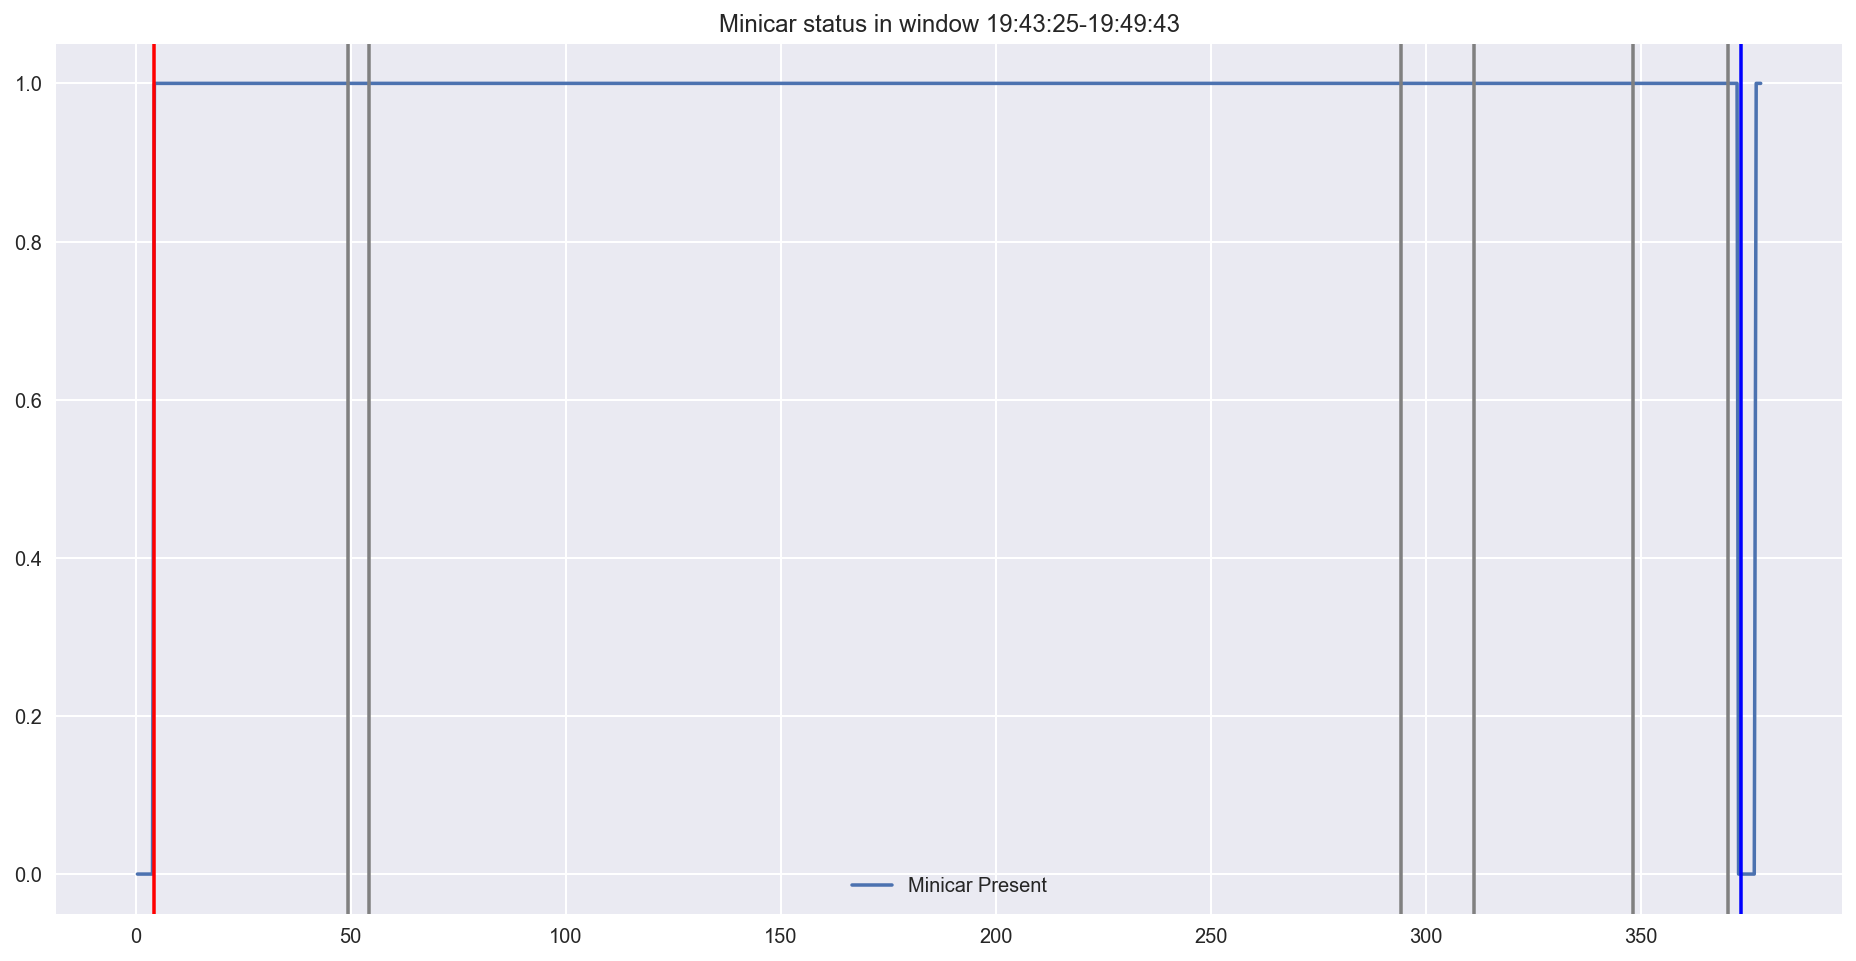

In [9]:
# minicar appearances
minicar = s.convertData('ACC_HUD','MINICAR',dataframe_window,db)
# subtract the start time to show relative time in the plot
pt.plot(minicar.Time-start,minicar.Message,label='Minicar Present')
pt.title('Minicar status in window ' + start_txt + '-' + end_txt)
pt.legend()
overlayEvents(pt.gca(), minicar_appears, minicar_disappears, cutin, fudgeFactor=videoFudgeFactor, relativeTime=start)

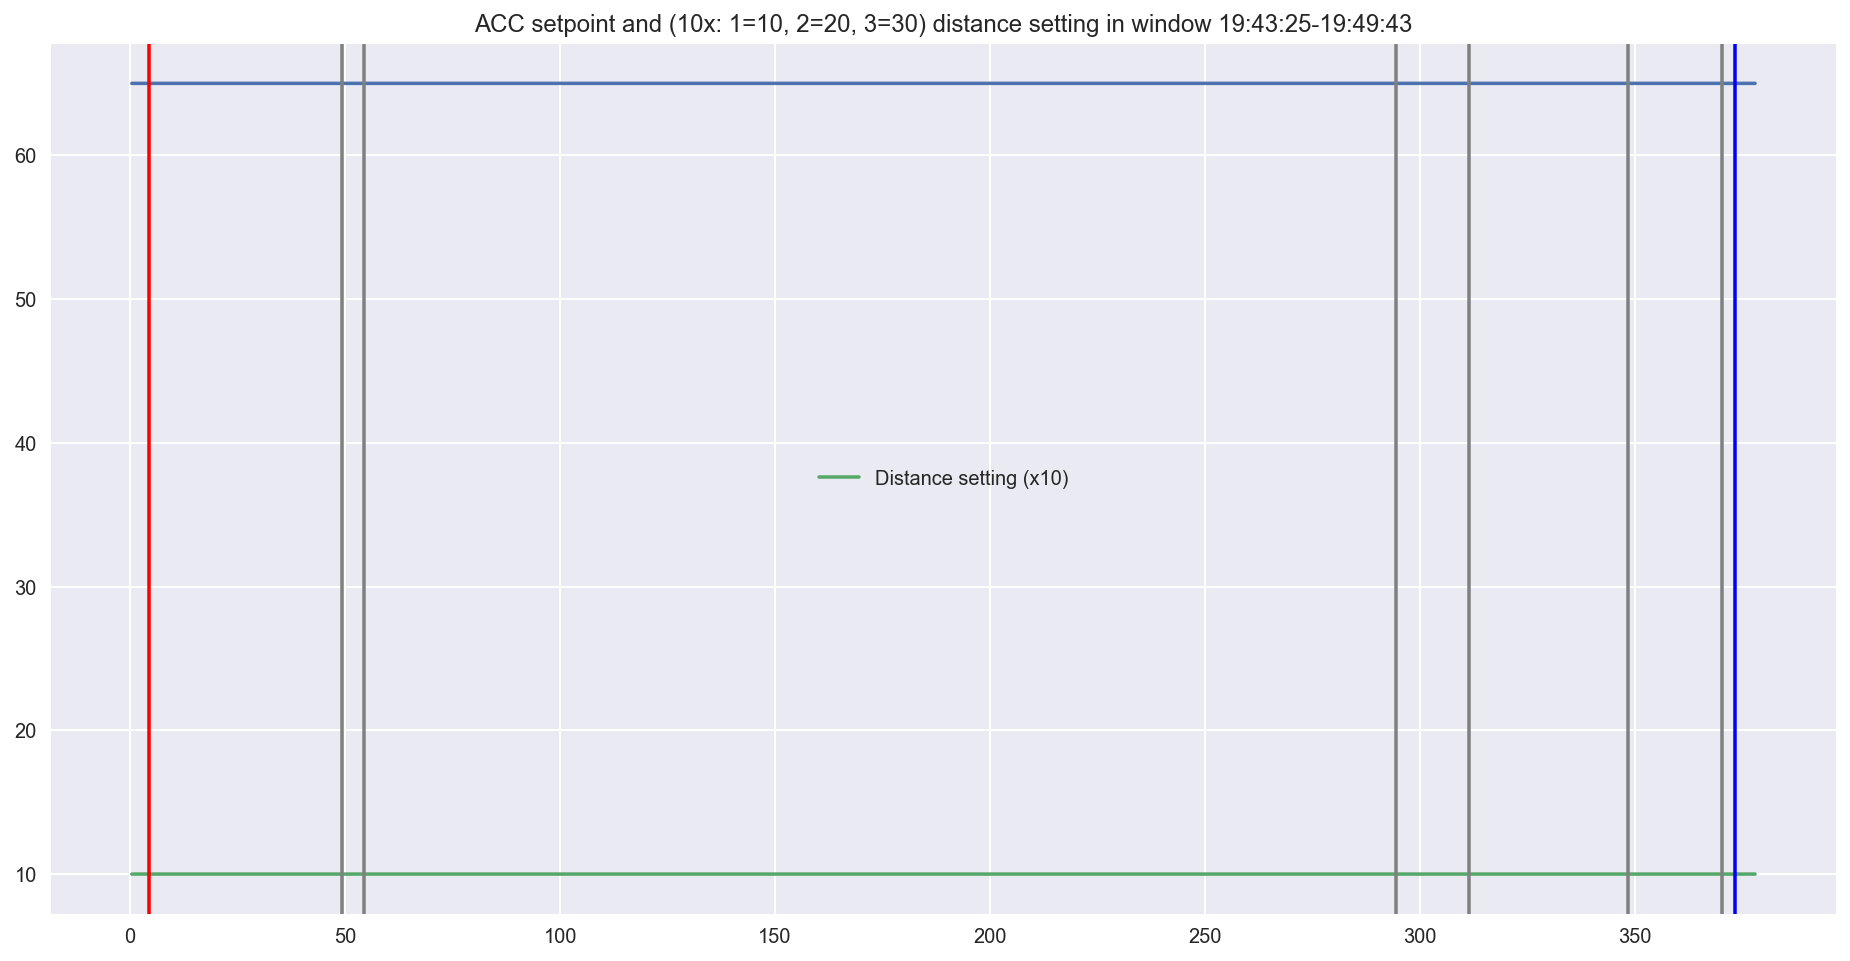

In [10]:
# acc setpoints and 'bar' settings
setpoint = s.convertData('ACC_HUD', 'SET_SPEED', dataframe_window, db)
distance_setting = s.convertData('ACC_HUD', 'SET_DISTANCE', dataframe_window, db)
# subtract the start time to show relative time in the plot
pt.plot(setpoint.Time-start,setpoint.Message)
# multiple distance setting by 10 to have it be more easily readable
pt.plot(distance_setting.Time-start, distance_setting.Message*10, label='Distance setting (x10)')
pt.title('ACC setpoint and (10x: 1=10, 2=20, 3=30) distance setting in window ' + start_txt + '-' + end_txt)
pt.legend()
overlayEvents(pt.gca(), minicar_appears, minicar_disappears, cutin, 
              fudgeFactor=videoFudgeFactor, relativeTime=start)

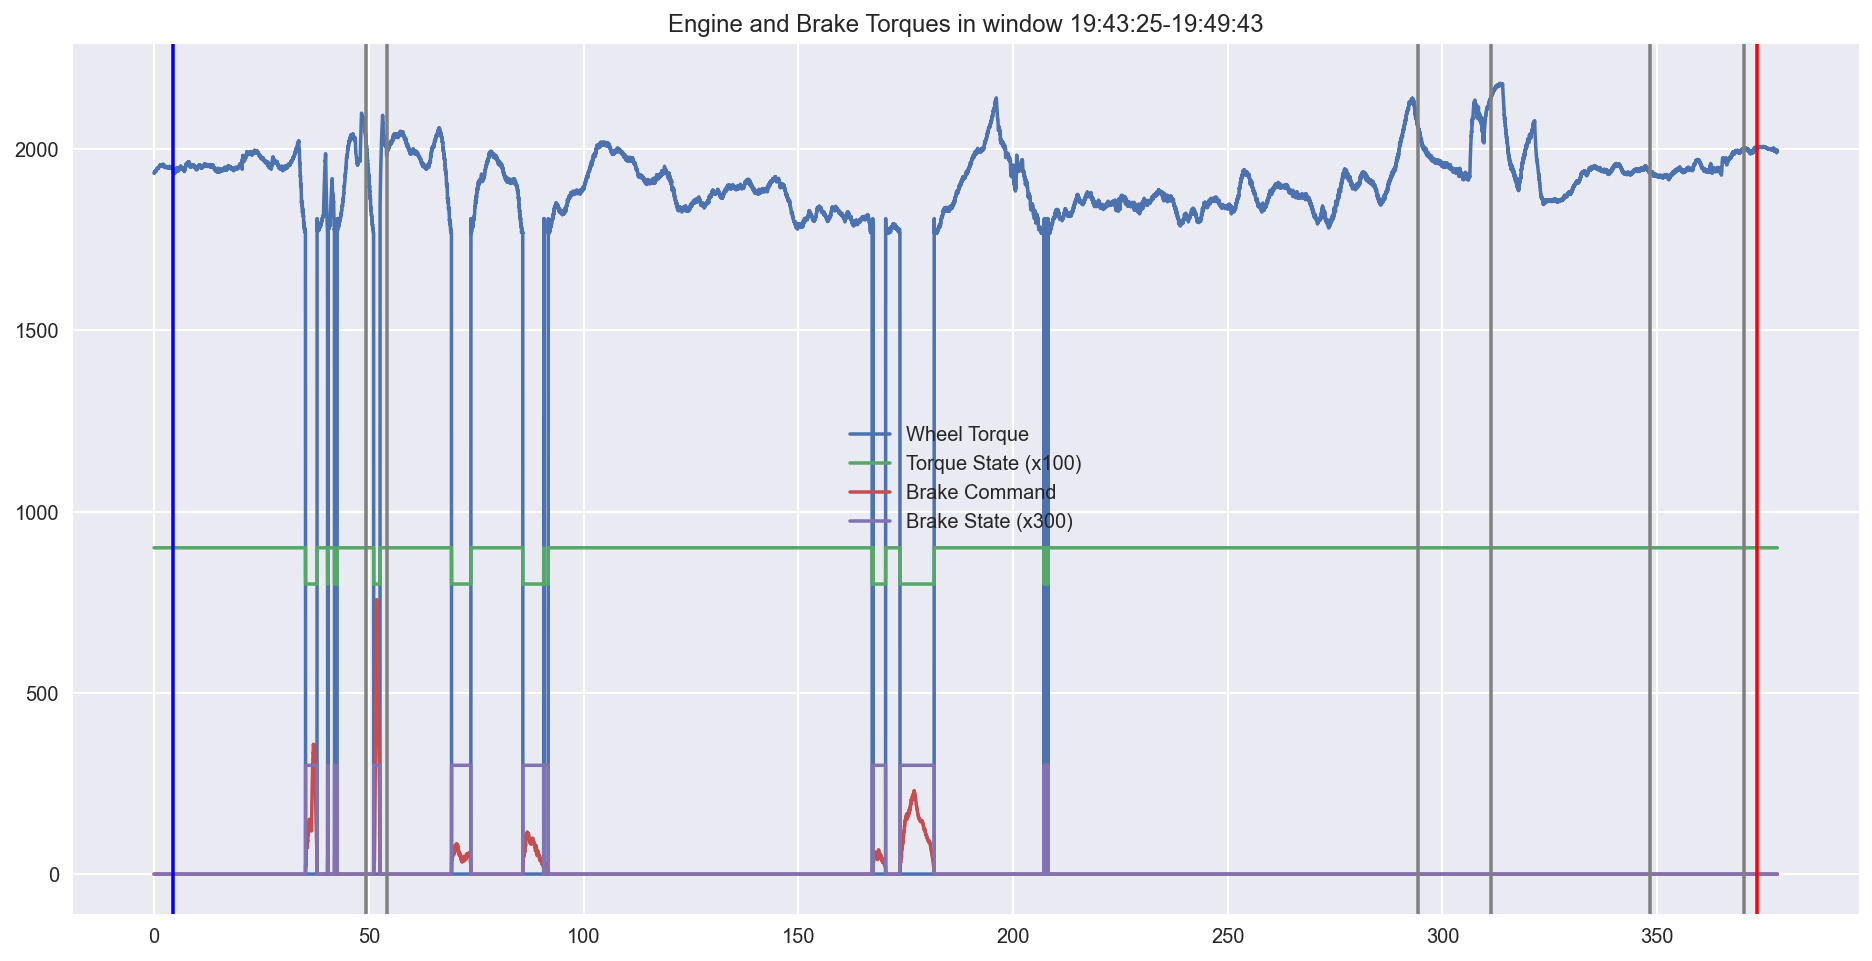

In [11]:
# wheel torque commands
remove_308_shorts = dataframe_window[dataframe_window['MessageLength']==64]
torques = s.convertData('CRUISE', 'WHEEL_TORQUE_CMD', remove_308_shorts, db)
torque_active = s.convertData('CRUISE', 'CRUISE_TORQUE_STATE', remove_308_shorts, db)
# subtract the start time to show relative time in the plot
pt.plot(torques.Time-start,torques.Message, label='Wheel Torque')
pt.plot(torque_active.Time-start,torque_active.Message*100, label='Torque State (x100)')


brakes = s.convertData('CRUISE', 'BRAKE_TORQUE_CMD', remove_308_shorts, db)
pt.plot(brakes.Time-start,brakes.Message,label='Brake Command')

brakes_active = s.convertData('CRUISE', 'BRAKE_TORQUE_ACTIVE', remove_308_shorts, db)
pt.plot(brakes_active.Time-start,brakes_active.Message*300, label='Brake State (x300)')

pt.title('Engine and Brake Torques in window ' + start_txt + '-' + end_txt)
pt.legend()
overlayEvents(pt.gca(), minicar_disappears, minicar_appears, cutin, 
              fudgeFactor=videoFudgeFactor, relativeTime=start)




The 286 message looks like it has some interesting signal information, but might be more tied to catching up to someone?

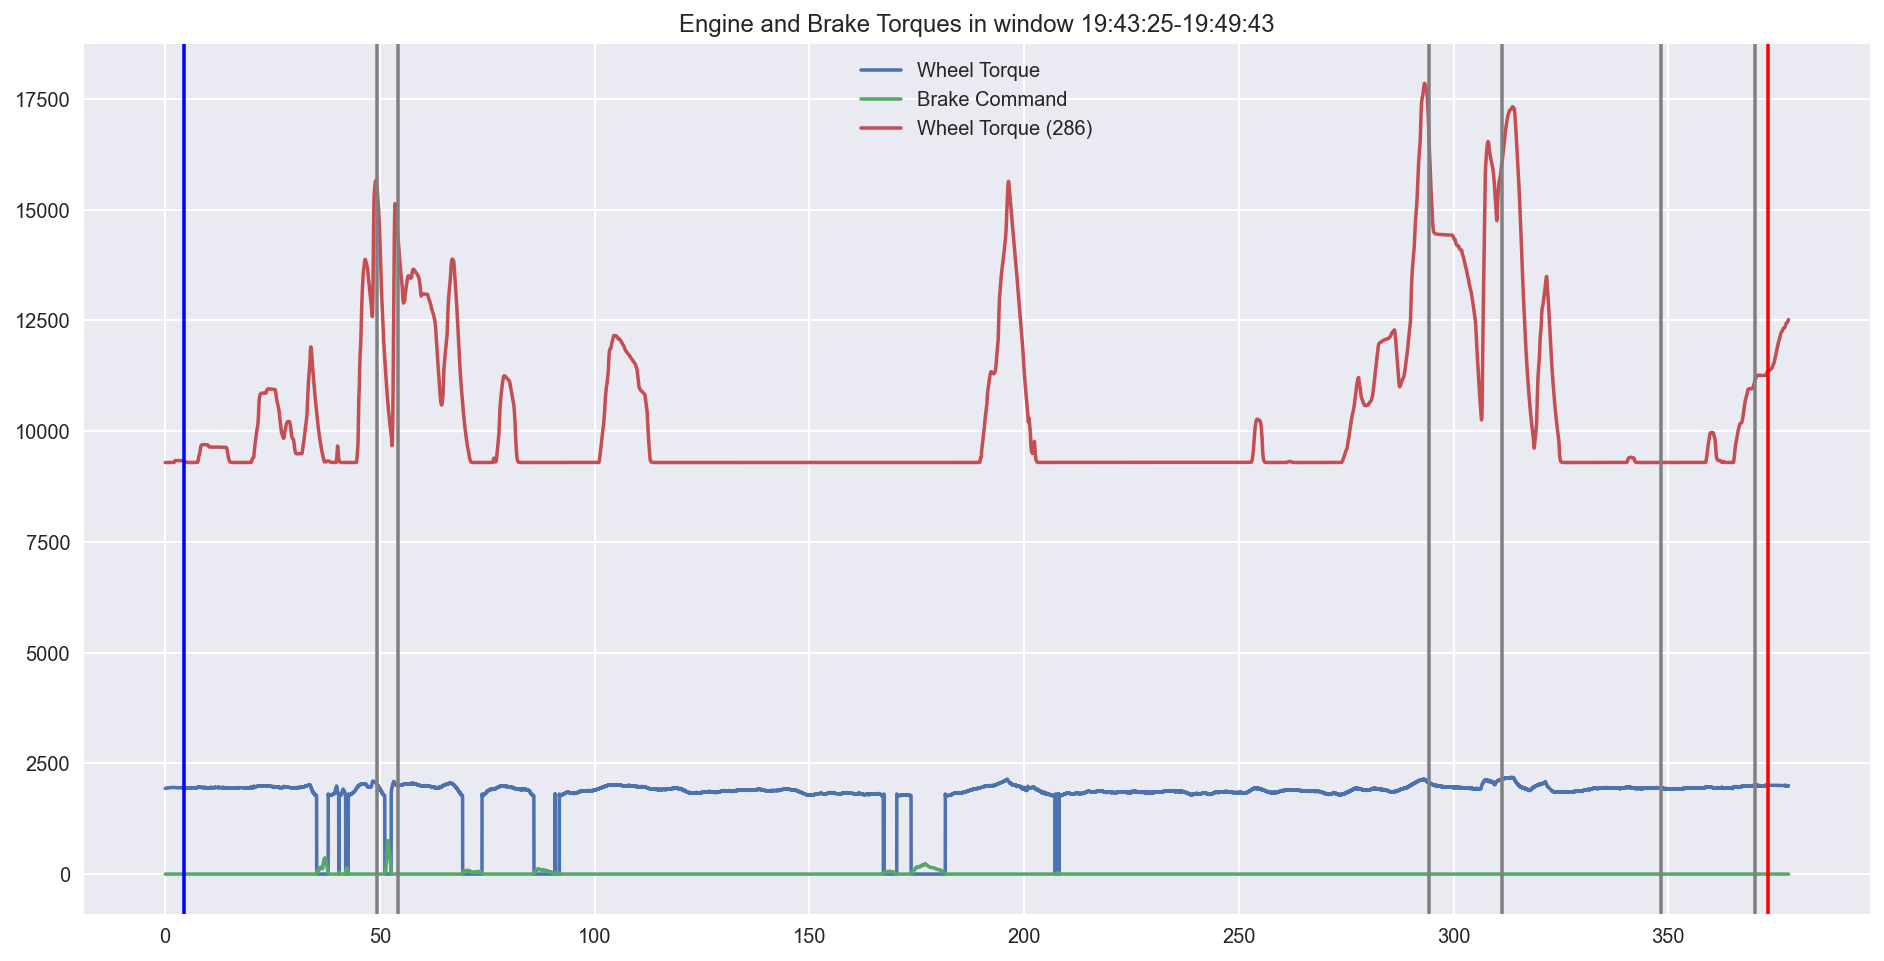

In [12]:
# there is another feed that looks like it has wheel torques at Msg 286; let's compare it:
# wheel torque commands
remove_308_shorts = dataframe_window[dataframe_window['MessageLength']==64]
torques = s.convertData('CRUISE', 'WHEEL_TORQUE_CMD', remove_308_shorts, db)
# subtract the start time to show relative time in the plot
pt.plot(torques.Time-start,torques.Message, label='Wheel Torque')

brakes = s.convertData('CRUISE', 'BRAKE_TORQUE_CMD', remove_308_shorts, db)
pt.plot(brakes.Time-start,brakes.Message,label='Brake Command')


u286 = s.convertData('TWO_EIGHTY_SIX', 'WHEEL_TORQUE_CMD', dataframe_window, db)
pt.plot(u286.Time-start,u286.Message, label='Wheel Torque (286)')

pt.title('Engine and Brake Torques in window ' + start_txt + '-' + end_txt)
pt.legend()
overlayEvents(pt.gca(), minicar_disappears, minicar_appears, cutin, 
              fudgeFactor=videoFudgeFactor, relativeTime=start)



## Get side radar/sensor information into scope

In later drives, we'll be getting this information all in one CAN file, but for now we are needing to capture it in two different ones. So in order to have the other data side-by-side, we will read in and sample the other dataset in the same timeframe.

In [13]:
dataframe_side_window = getTimeWindow(dataframe_side,start,end)

In [14]:
dataframe_side_window

,Time,Bus,MessageID,Message,MessageLength
4672825,1.663617e+09,2,407,91fde000e41c5589840c04381809c9809b6b9c055e57b1...,64.0
4672826,1.663617e+09,0,407,91fde000e41c5589840c04381809c9809b6b9c055e57b1...,64.0
4672827,1.663617e+09,2,412,826ae000e41c55888aa402221e9cc90082d83c022ea1f9...,64.0
4672828,1.663617e+09,0,412,826ae000e41c55888aa402221e9cc90082d83c022ea1f9...,64.0
4672829,1.663617e+09,1,545,9c4000,3.0
...,...,...,...,...,...
5809747,1.663617e+09,1,813,00000000,4.0
5809748,1.663617e+09,1,607,00025f03fda000000000393922d7cdc2ebb99d7c,20.0
5809749,1.663617e+09,2,303,00012f07bd9026108e21ca00,12.0
5809750,1.663617e+09,0,303,00012f07bd9026108e21ca00,12.0


There are dozens or more side radar signals, we select a few of them below and try to indicate whether they are left or right.

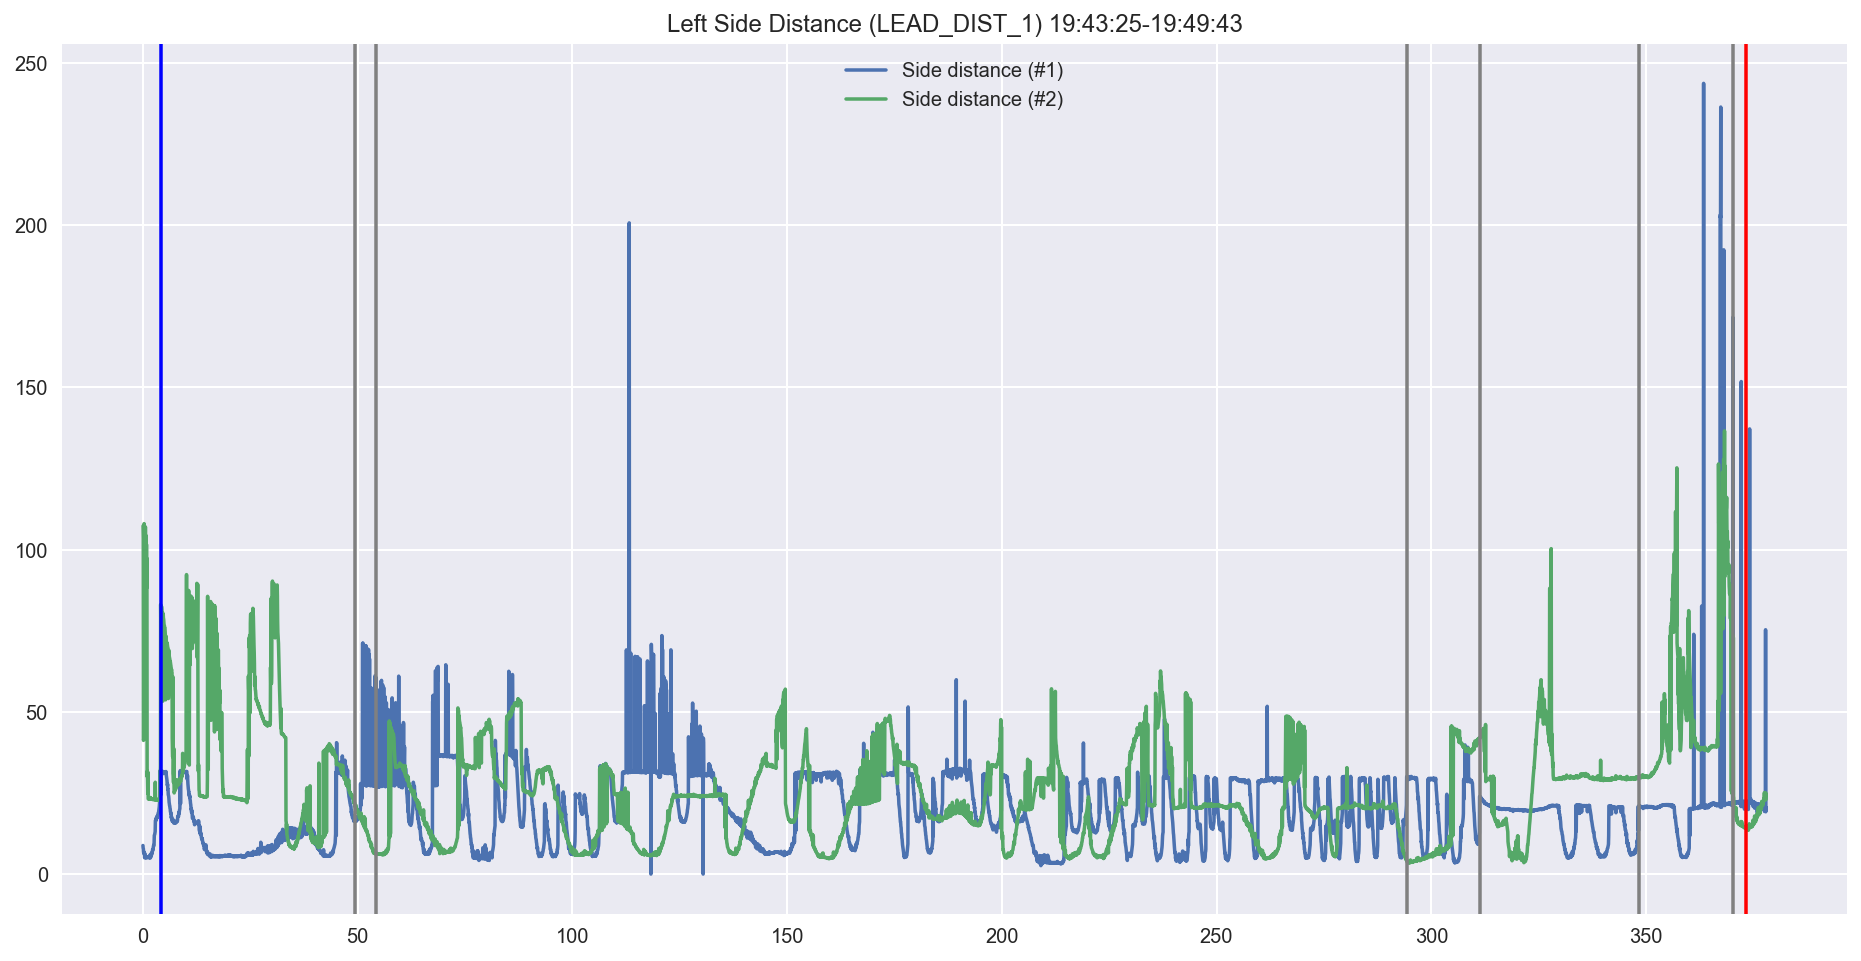

In [15]:
side_1 = s.convertData('RADAR_SENSOR1','LEAD_DIST1',dataframe_side_window,db)
pt.plot(side_1.Time-start,side_1.Message,label='Side distance (#1)')

side_2 = s.convertData('RADAR_SENSOR2','LEAD_DIST1',dataframe_side_window,db)
pt.plot(side_2.Time-start,side_2.Message,label='Side distance (#2)')

# side_1a = s.convertData('RADAR_SENSOR3','LEAD_DIST1',dataframe_side_window,db)
# pt.plot(side_1a.Time-start,side_1a.Message,label='Side distance (#1), raw data of #1')

# side_2a = s.convertData('RADAR_SENSOR4','LEAD_DIST1',dataframe_side_window,db)
# pt.plot(side_2a.Time-start,side_2a.Message,label='Side distance (#2), raw data of #2')

# come back and look at this one later
# side_15 = s.convertData('RADAR_SENSOR15','LEAD_DIST1',dataframe_side_window,db)
# pt.plot(side_15.Time-start,side_15.Message,label='Side distance (#15)')
# side_17 = s.convertData('RADAR_SENSOR17','LEAD_DIST1',dataframe_side_window,db)
# pt.plot(side_17.Time-start,side_17.Message,label='Side distance (#17)')

# side_17 = s.convertData('RADAR_SENSOR20','LEAD_DIST1',dataframe_side_window,db)
# pt.plot(side_17.Time-start,side_17.Message,label='Side distance (#17)')

pt.title('Left Side Distance (LEAD_DIST_1) ' + start_txt + '-' + end_txt)
pt.legend()
overlayEvents(pt.gca(), minicar_disappears, minicar_appears, cutin, 
              fudgeFactor=videoFudgeFactor, relativeTime=start)



Some sensors we don't know what they are, but we can plot them by using the DBC file against existing marks entered by the user.

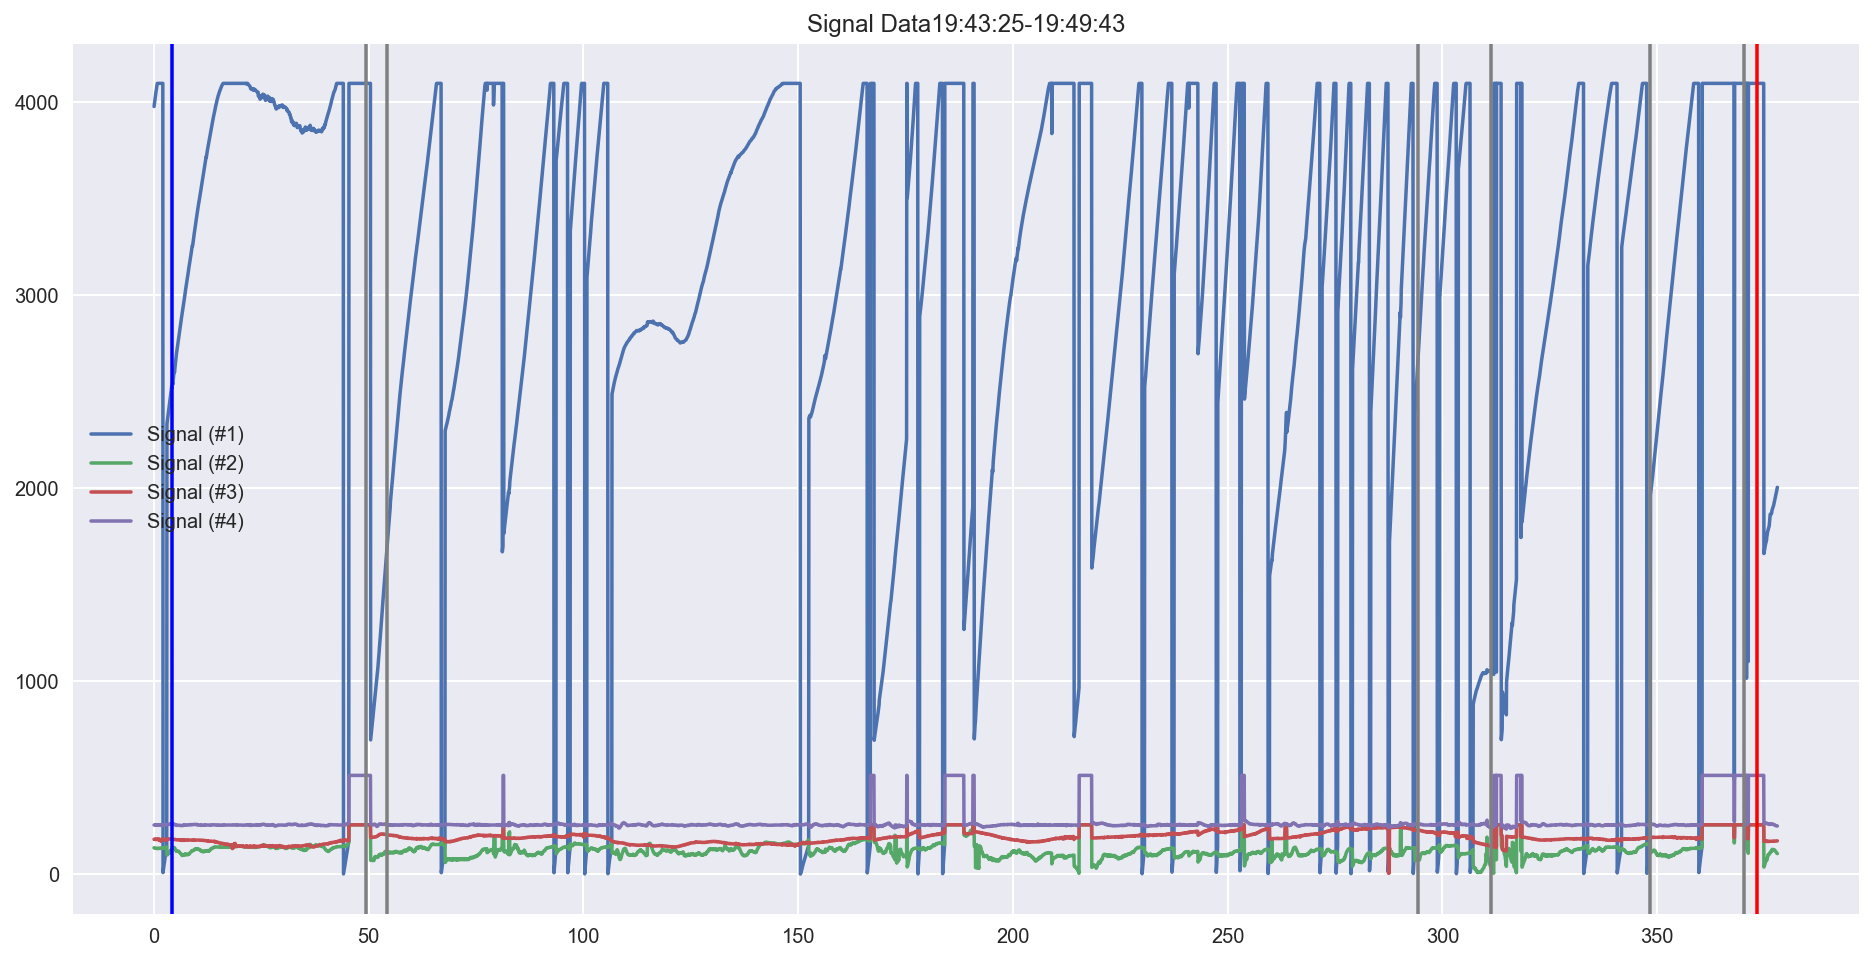

In [16]:
# look at bonus sensors
sig1 = s.convertData('BONUS_RADAR1','SIG1',dataframe_side_window,db)
pt.plot(sig1.Time-start,sig1.Message,label='Signal (#1)')

sig2 = s.convertData('BONUS_RADAR1','SIG2',dataframe_side_window,db)
pt.plot(sig2.Time-start,sig2.Message,label='Signal (#2)')

sig3 = s.convertData('BONUS_RADAR1','SIG3',dataframe_side_window,db)
pt.plot(sig3.Time-start,sig3.Message,label='Signal (#3)')

sig4 = s.convertData('BONUS_RADAR1','SIG4',dataframe_side_window,db)
pt.plot(sig4.Time-start,sig4.Message,label='Signal (#4)')


pt.title('Signal Data' + start_txt + '-' + end_txt)
pt.legend()
overlayEvents(pt.gca(), minicar_disappears, minicar_appears, cutin, 
              fudgeFactor=videoFudgeFactor, relativeTime=start)




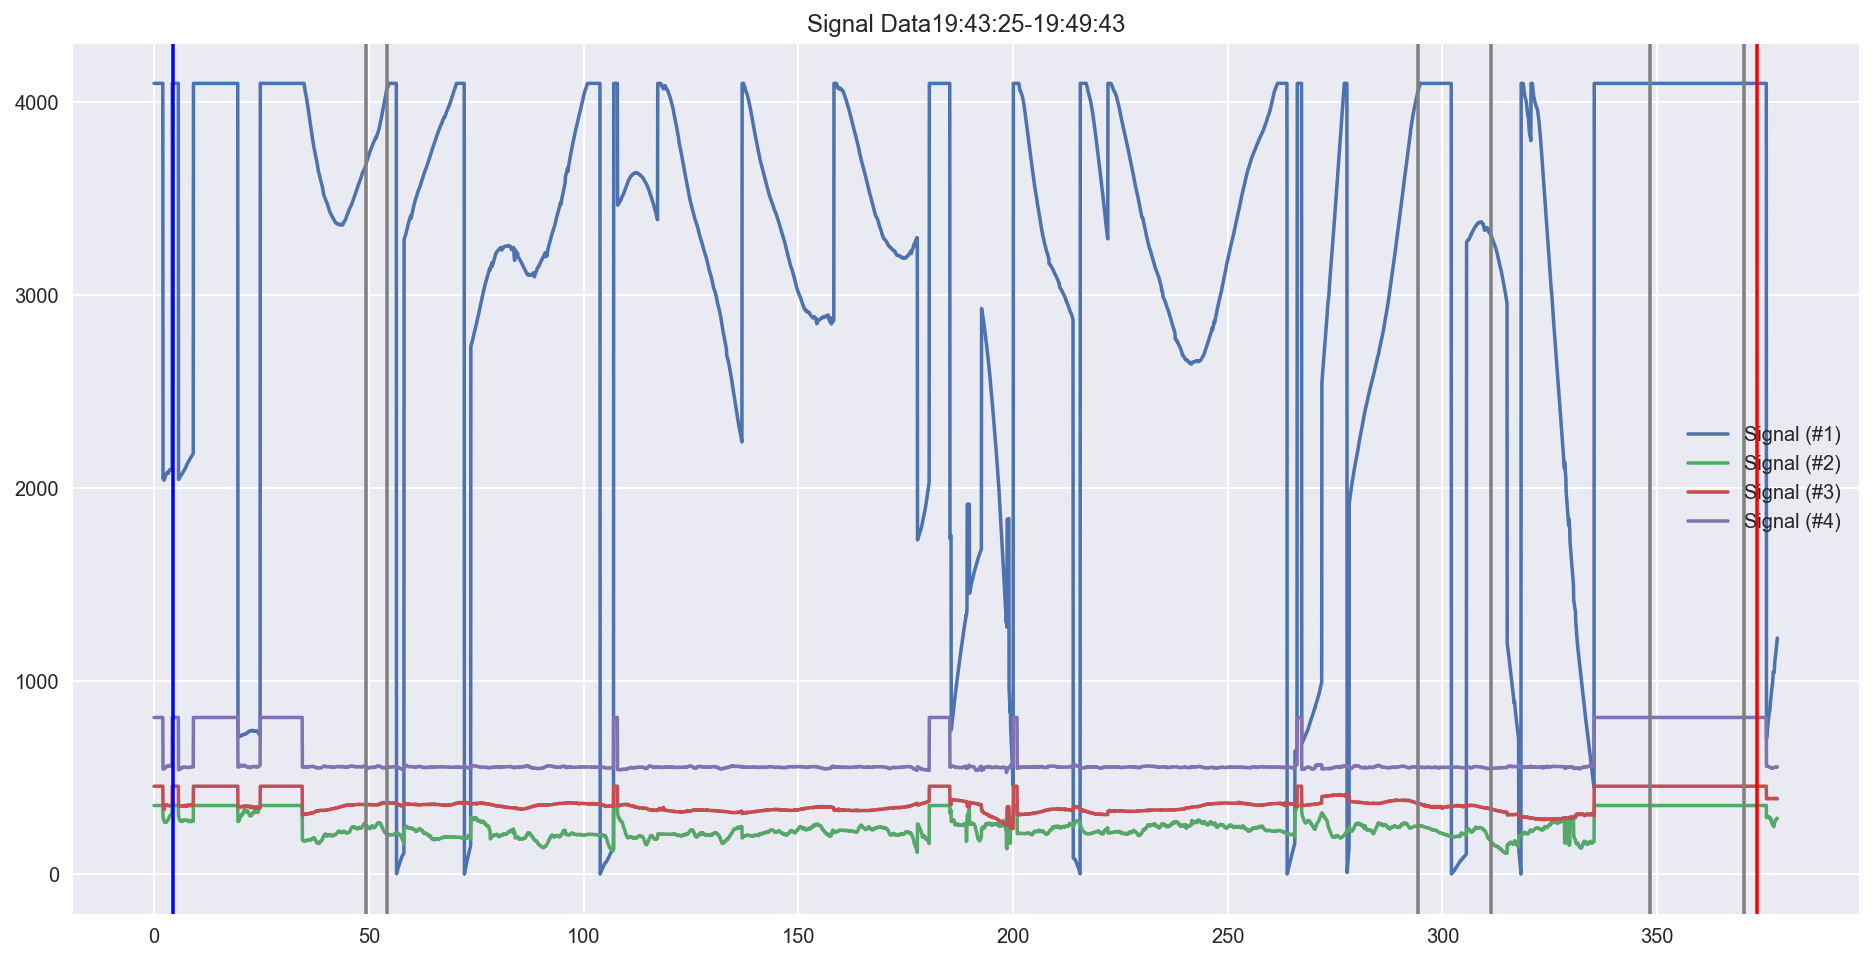

In [17]:
# look at bonus sensors
sig1 = s.convertData('BONUS_RADAR2','SIG1',dataframe_side_window,db)
pt.plot(sig1.Time-start,sig1.Message,label='Signal (#1)')

# all these signals seem to be the same, try uncommenting if you want to explore otherwise
sig2 = s.convertData('BONUS_RADAR2','SIG2',dataframe_side_window,db)
pt.plot(sig2.Time-start,sig2.Message+100,label='Signal (#2)')

sig3 = s.convertData('BONUS_RADAR2','SIG3',dataframe_side_window,db)
pt.plot(sig3.Time-start,sig3.Message+200,label='Signal (#3)')

sig4 = s.convertData('BONUS_RADAR2','SIG4',dataframe_side_window,db)
pt.plot(sig4.Time-start,sig4.Message+300,label='Signal (#4)')


pt.title('Signal Data' + start_txt + '-' + end_txt)
pt.legend()
overlayEvents(pt.gca(), minicar_disappears, minicar_appears, cutin, 
              fudgeFactor=videoFudgeFactor, relativeTime=start)





In [18]:
# look at different video subset
# list important times that are gathered from dashcam information
# once more with more information to validate across a longer time horizon
pass_on_left = []
passed_on_left = []
cutin = []

start = getUnixTimeFromTimestamp('2022-09-19 20:32:45') 
pass_on_left.append(getUnixTimeFromTimestamp('2022-09-19 20:32:57')) # we pass car
passed_on_left.append(getUnixTimeFromTimestamp('2022-09-19 20:33:09')) # car passes us back
end = getUnixTimeFromTimestamp('2022-09-19 20:33:17') + 10

# text of start/end times
start_txt = datetime.utcfromtimestamp(start).strftime('%H:%M:%S')
end_txt = datetime.utcfromtimestamp(end).strftime('%H:%M:%S')

# videoFudgeFactor: difference between time for video, and time for the rpi
videoFudgeFactor=1.3

print('Video timestamps should run from ', start_txt,' to ', end_txt, 
      ', and will be approximately', videoFudgeFactor, 's behind the CAN data.')



Video timestamps should run from  19:32:45  to  19:33:27 , and will be approximately 1.3 s behind the CAN data.


In [19]:
# TODO go back and select new drive subset
df_side_double_pass = getTimeWindow(dataframe_side,start,end)

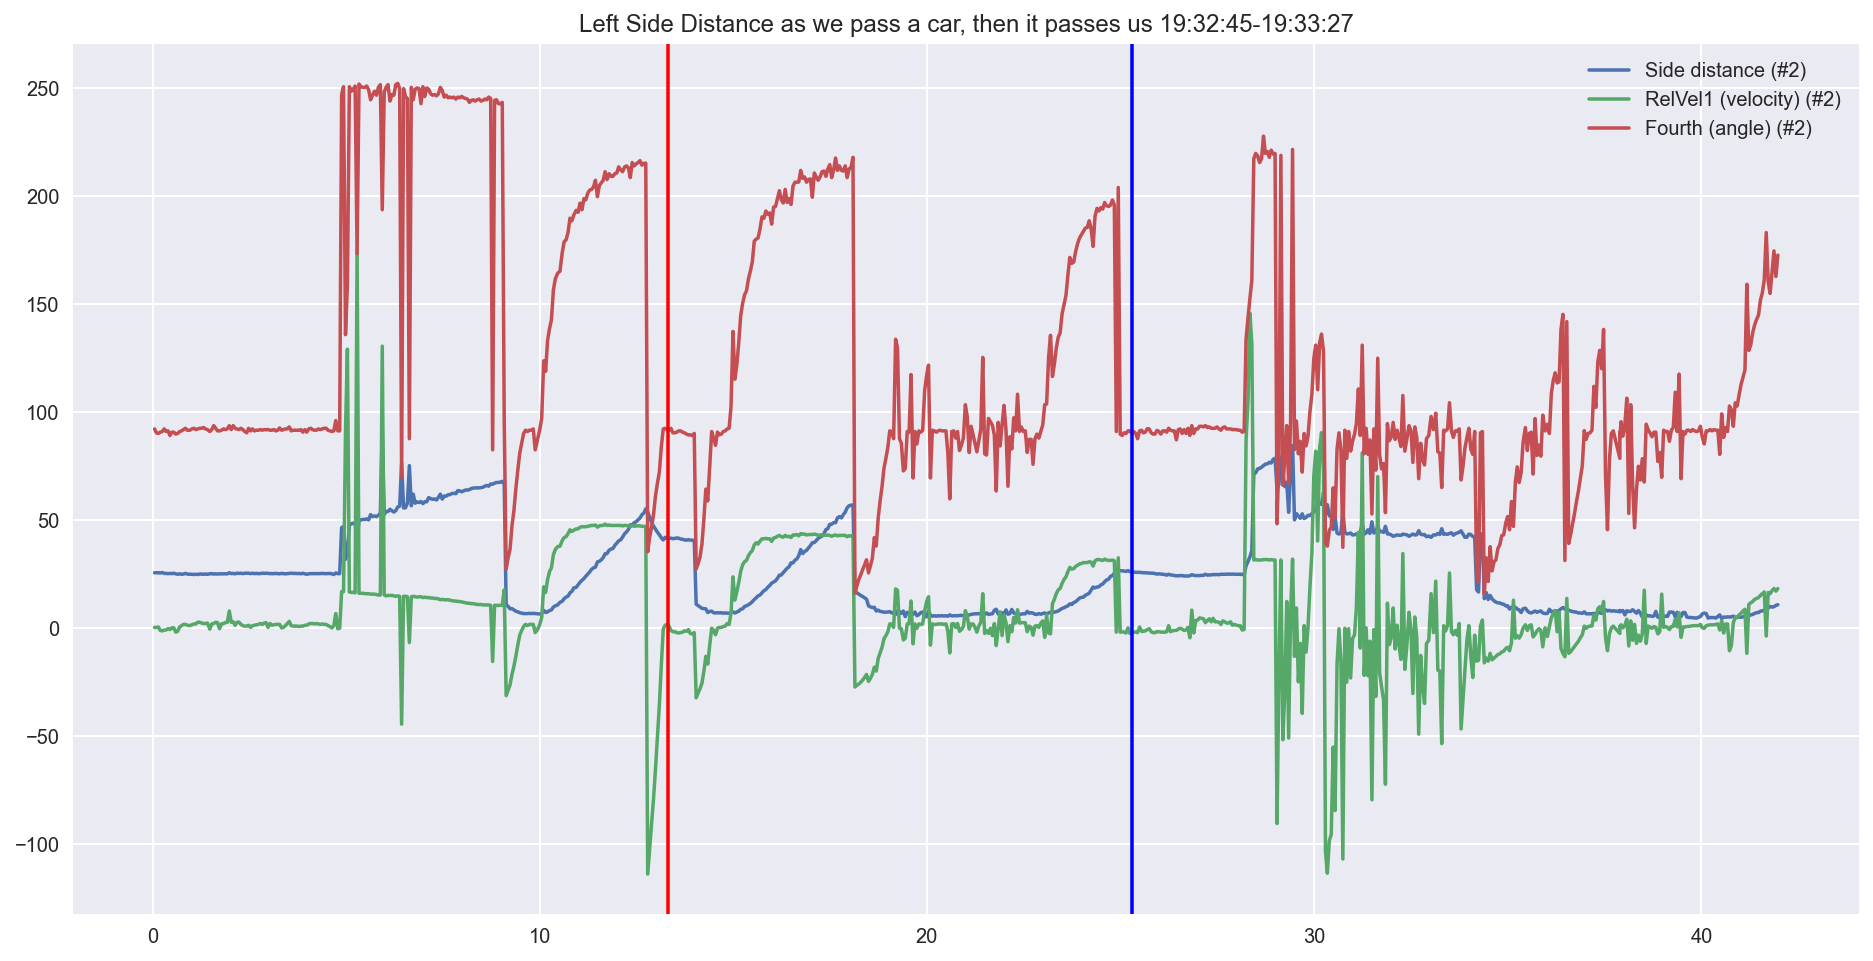

In [49]:
# side_1 = s.convertData('RADAR_SENSOR1','LEAD_DIST1',dataframe_side_window,db)
# pt.plot(side_1.Time-start,side_1.Message,label='Side distance (#1)')

side_2_dist = s.convertData('RADAR_SENSOR2','LEAD_DIST1',df_side_double_pass,db)
pt.plot(side_2_dist.Time-start,side_2_dist.Message,label='Side distance (#2)')

side_2_angle = s.convertData('RADAR_SENSOR2','REL_VEL1',df_side_double_pass,db)
pt.plot(side_2_angle.Time-start,side_2_angle.Message,label='RelVel1 (velocity) (#2)')

side_2_rel_speed = s.convertData('RADAR_SENSOR2','FOURTH1',df_side_double_pass,db)
pt.plot(side_2_rel_speed.Time-start,side_2_rel_speed.Message,label='Fourth (angle) (#2)')




# side_1a = s.convertData('RADAR_SENSOR3','LEAD_DIST1',dataframe_side_window,db)
# pt.plot(side_1a.Time-start,side_1a.Message,label='Side distance (#1), raw data of #1')

# side_2a = s.convertData('RADAR_SENSOR4','LEAD_DIST1',dataframe_side_window,db)
# pt.plot(side_2a.Time-start,side_2a.Message,label='Side distance (#2), raw data of #2')

# come back and look at this one later
# side_15 = s.convertData('RADAR_SENSOR15','LEAD_DIST1',dataframe_side_window,db)
# pt.plot(side_15.Time-start,side_15.Message,label='Side distance (#15)')
# side_17 = s.convertData('RADAR_SENSOR17','LEAD_DIST1',dataframe_side_window,db)
# pt.plot(side_17.Time-start,side_17.Message,label='Side distance (#17)')

# side_17 = s.convertData('RADAR_SENSOR20','LEAD_DIST1',dataframe_side_window,db)
# pt.plot(side_17.Time-start,side_17.Message,label='Side distance (#17)')

pt.title('Left Side Distance as we pass a car, then it passes us ' + start_txt + '-' + end_txt)
pt.legend()
overlayEvents(pt.gca(), pass_on_left, passed_on_left, [], 
              fudgeFactor=videoFudgeFactor, relativeTime=start)




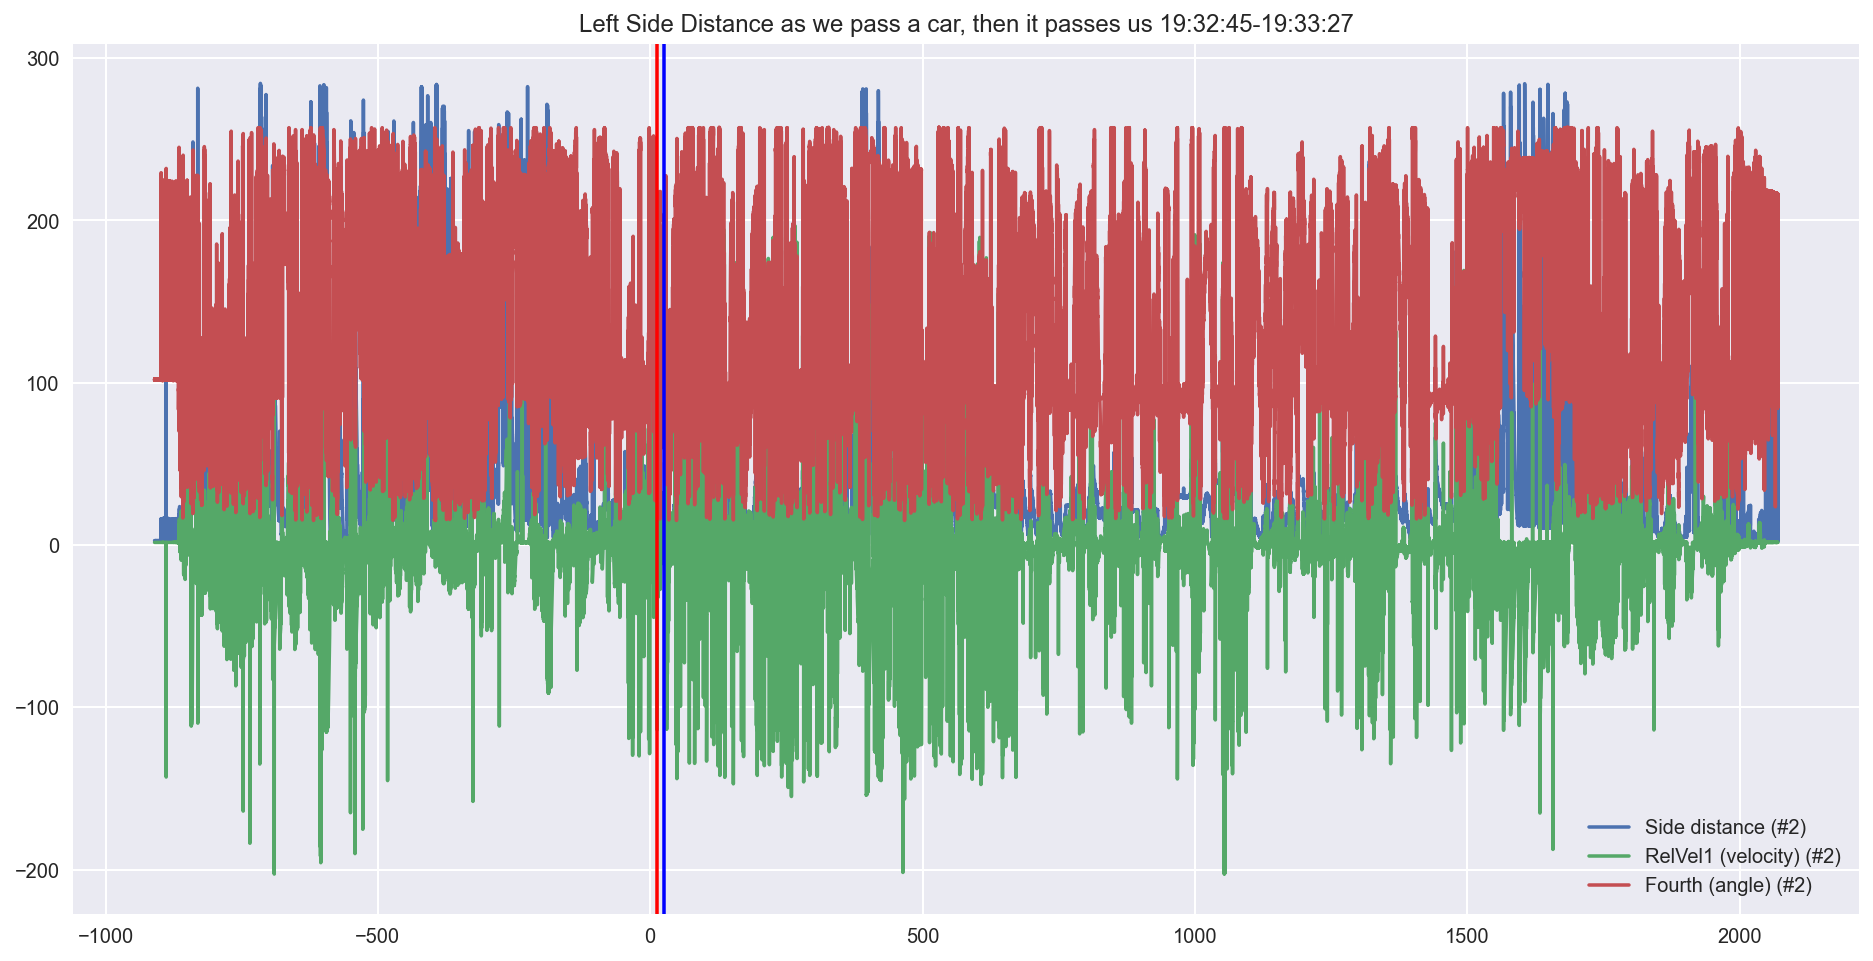

In [29]:
side_2_dist = s.convertData('RADAR_SENSOR2','LEAD_DIST1',dataframe_side,db)
pt.plot(side_2_dist.Time-start,side_2_dist.Message,label='Side distance (#2)')

side_2_angle = s.convertData('RADAR_SENSOR2','REL_VEL1',dataframe_side,db)
pt.plot(side_2_angle.Time-start,side_2_angle.Message,label='RelVel1 (velocity) (#2)')

side_2_rel_speed = s.convertData('RADAR_SENSOR2','FOURTH1',dataframe_side,db)
pt.plot(side_2_rel_speed.Time-start,side_2_rel_speed.Message,label='Fourth (angle) (#2)')




# side_1a = s.convertData('RADAR_SENSOR3','LEAD_DIST1',dataframe_side_window,db)
# pt.plot(side_1a.Time-start,side_1a.Message,label='Side distance (#1), raw data of #1')

# side_2a = s.convertData('RADAR_SENSOR4','LEAD_DIST1',dataframe_side_window,db)
# pt.plot(side_2a.Time-start,side_2a.Message,label='Side distance (#2), raw data of #2')

# come back and look at this one later
# side_15 = s.convertData('RADAR_SENSOR15','LEAD_DIST1',dataframe_side_window,db)
# pt.plot(side_15.Time-start,side_15.Message,label='Side distance (#15)')
# side_17 = s.convertData('RADAR_SENSOR17','LEAD_DIST1',dataframe_side_window,db)
# pt.plot(side_17.Time-start,side_17.Message,label='Side distance (#17)')

# side_17 = s.convertData('RADAR_SENSOR20','LEAD_DIST1',dataframe_side_window,db)
# pt.plot(side_17.Time-start,side_17.Message,label='Side distance (#17)')

pt.title('Left Side Distance as we pass a car, then it passes us ' + start_txt + '-' + end_txt)
pt.legend()
overlayEvents(pt.gca(), pass_on_left, passed_on_left, [], 
              fudgeFactor=videoFudgeFactor, relativeTime=start)




<AxesSubplot:>

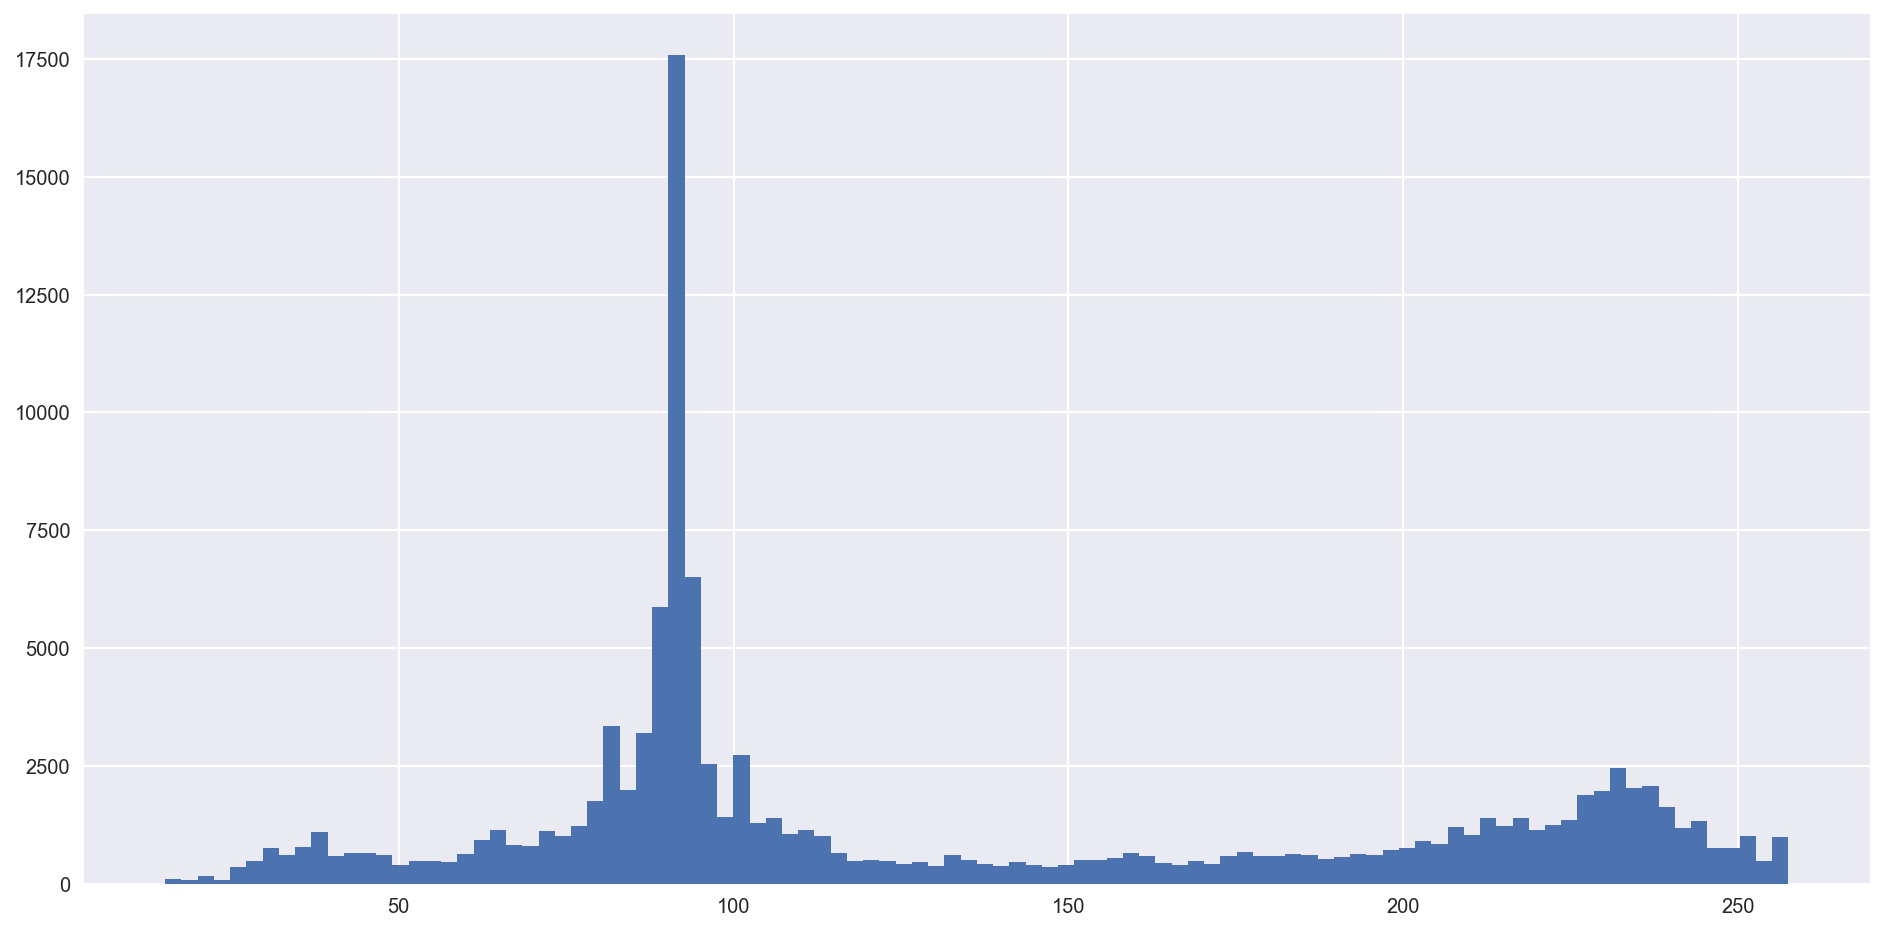

In [48]:
side_2_rel_speed.Message.hist(bins=100)
#257.507-15.13 = 242.377

In [38]:
side_2_rel_speed.Message.describe()
#257.507-15.13 = 242.377

count    118190.000000
mean        132.958152
std          65.658346
min          15.131820
25%          89.057760
50%          97.256940
75%         203.579640
max         257.507580
Name: Message, dtype: float64

In [44]:
242.377/180

1.346538888888889

<AxesSubplot:>

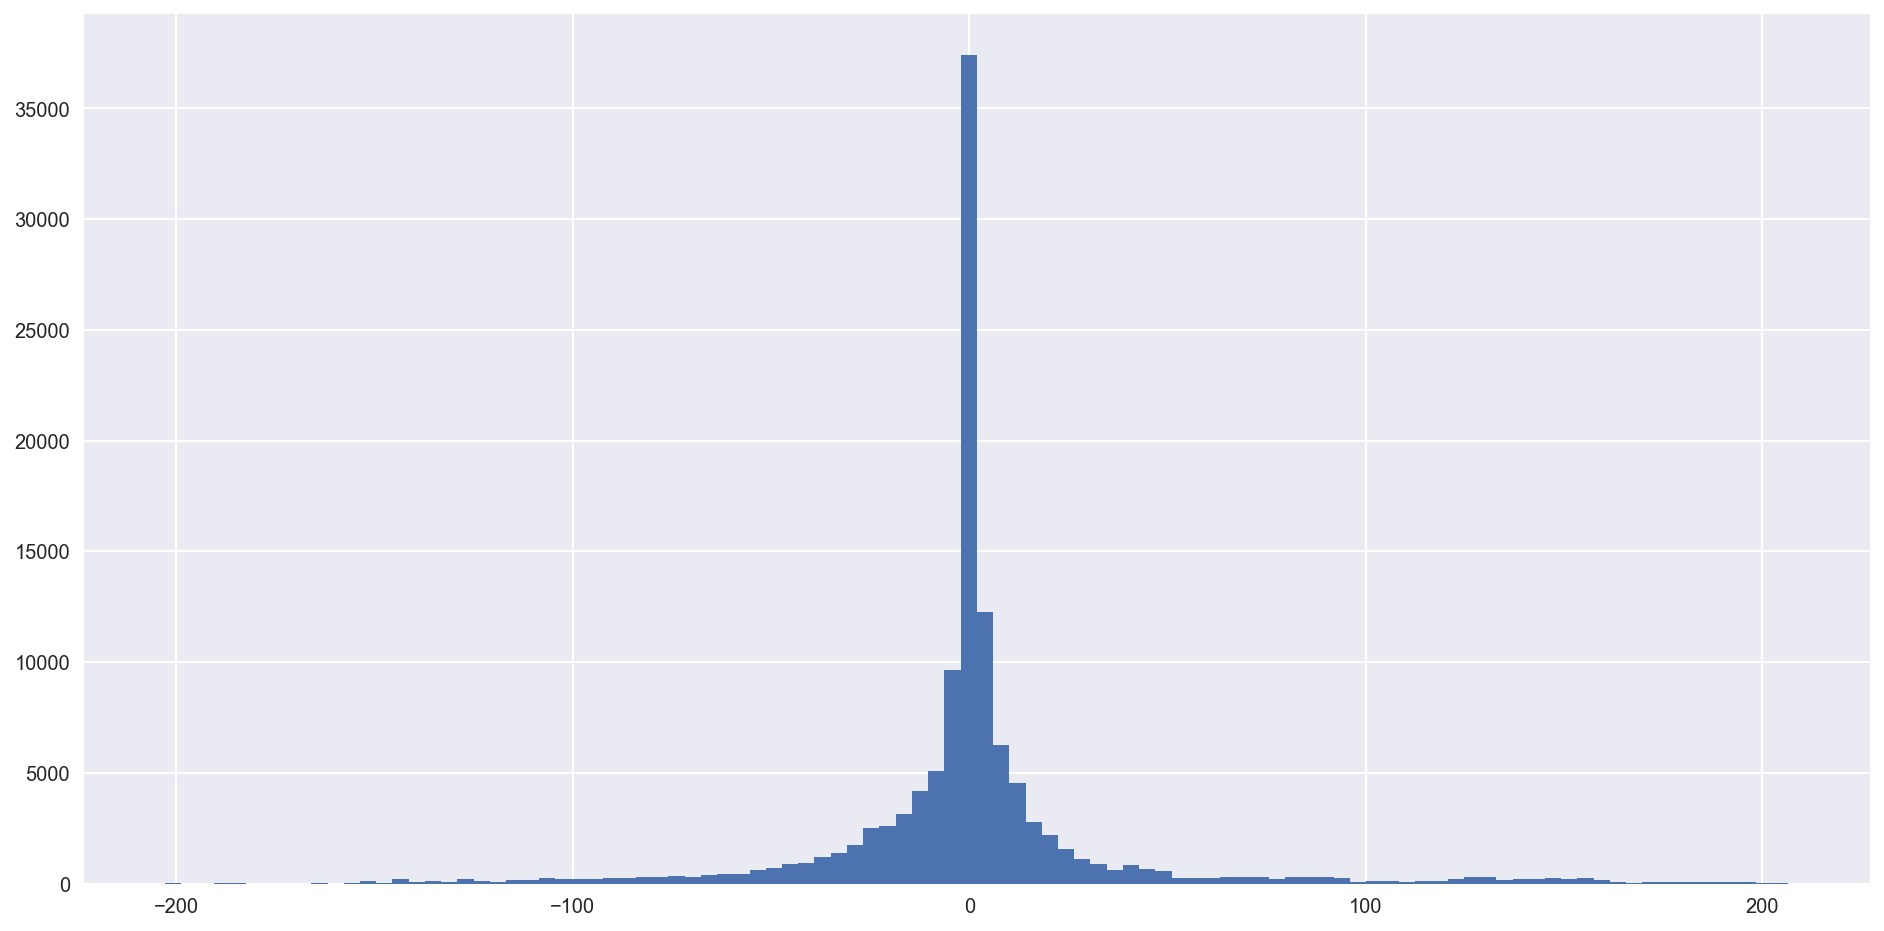

In [31]:
side_2_angle.Message.hist(bins=100)